In [1]:
import boto3
import pandas as pd
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
from ladybug.epw import EPW
from lightning.pytorch import Trainer
import torch
import numpy as np

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from utils.constants import JOULES_TO_KWH
from weather.weather import extract

from archetypal import settings

if os.name == "nt":
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("C:/EnergyPlusV22-2-0")
else:
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("/usr/local/EnergyPlus-22-2-0")

from archetypal.idfclass import IDF

Couldn't import dot_parser, loading of dot files will not be possible.


c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package energy-pandas is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
bucket = "ml-for-bem"
s3 = boto3.client("s3")

data_root = Path("data") / "temp" / "validate"
experiment_root = "idf/batch/validation_v1/"
city = "seattle"
batch_id = "42c8a652"
should_gather = False

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [3]:
# list objects in bucket using paginator
def get_files_in_experiment(experiment):
    print("Listing files for experiment: ", experiment, "...")
    files = []
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=experiment):
        if page.get("Contents"):
            for obj in page["Contents"]:
                files.append(obj["Key"])
    return files


def download(file):
    filepath = data_root / file
    os.makedirs(filepath.parent, exist_ok=True)
    s3.download_file(bucket, file, filepath)
    return filepath


def download_and_open_json(file):
    filepath = download(file)
    with open(filepath, "r") as f:
        return json.load(f)


def download_and_open_hdf(file):
    filepath = download(file)
    return pd.read_hdf(filepath)


def get_weather(city):
    experiment_folder = experiment_root + city + "/"
    weather_folder = experiment_folder + "epw"
    # list files in weather folder
    weather_files = get_files_in_experiment(weather_folder)
    with ThreadPoolExecutor(max_workers=8) as executor:
        weather_files = list(
            tqdm(executor.map(download, weather_files), total=len(weather_files))
        )
    return weather_files


def download_and_open_ground_truth(city, batch_id):
    file = experiment_root + city + "/" + batch_id + "/Buildings.hdf"
    true_df = download_and_open_hdf(file)

    true_df = true_df.sort_index(level="file_name")
    building_id = true_df.index.to_frame()["file_name"].str.split("_").str[1]
    building_id.name = "building_id"
    true_df = true_df.set_index(building_id, append=True)
    true_df = true_df * JOULES_TO_KWH
    return true_df

## Gather/Download Validation Files


In [4]:
geometry_files = get_files_in_experiment(experiment_root + "geometry")
parameter_files = get_files_in_experiment(experiment_root + "parameters")
template_files = get_files_in_experiment(experiment_root + "template")

Listing files for experiment:  idf/batch/validation_v1/geometry ...
Listing files for experiment:  idf/batch/validation_v1/parameters ...
Listing files for experiment:  idf/batch/validation_v1/template ...


In [5]:
if should_gather:
    print("Gathering individual geometry files...")
    with ThreadPoolExecutor(max_workers=8) as executor:
        geometry = list(
            tqdm(
                executor.map(download_and_open_json, geometry_files),
                total=len(geometry_files),
            )
        )

    with open(data_root / "geometry.json", "w") as f:
        json.dump(geometry, f)

    # upload geometry to s3
    s3.upload_file(
        str(data_root / "geometry.json"), bucket, experiment_root + "geometry.json"
    )
else:
    print("Using cached geometry from s3...")
    geometry = download_and_open_json(experiment_root + "geometry.json")

Using cached geometry from s3...


In [6]:
if should_gather:
    print("Gathering individual parameter files from s3...")
    with ThreadPoolExecutor(max_workers=8) as executor:
        parameters = list(
            tqdm(
                executor.map(download_and_open_hdf, parameter_files),
                total=len(parameter_files),
            )
        )
        parameters = pd.concat(parameters, ignore_index=True, axis=0)

    for col in parameters.columns:
        if parameters[col].dtype == "object":
            if col not in ["name", "building_id", "facade_normal", "idf_path", "vert"]:
                parameters[col] = (
                    parameters[col].astype("float")
                    if col != "floor"
                    else parameters[col].astype("int")
                )
    # save and upload to s3
    n_floors = parameters.groupby("building_id").max()["floor"] + 1
    n_floors.name = "n_floors"
    parameters = parameters.merge(
        n_floors, right_on="building_id", left_on="building_id"
    )
    parameters["weight"] = parameters["edge_weight"] / parameters["n_floors"]
    parameters.to_hdf(data_root / "parameters.hdf", key="df")
    s3.upload_file(
        str(data_root / "parameters.hdf"), bucket, experiment_root + "sb_parameters.hdf"
    )
else:
    print("Using cached parameters from s3...")
    parameters_fp = experiment_root + "sb_parameters.hdf"
    parameters_fp = download(parameters_fp)
    parameters = pd.read_hdf(parameters_fp, key="df")
parameters = parameters.set_index(["building_id", "name"])

Using cached parameters from s3...


In [12]:
parameters.loc[("781038433", slice(None))].iloc[0]

facade_length                                                  37.578133
distance_to_bldg_cent                                          34.461826
facade_normal            [-14.443713425120784, -34.691428680992104, 0.0]
edge_weight                                                      0.17642
orientation                                                     5.888666
floor                                                                  0
perim_area                                                     538.60031
core_area                                                    3965.542834
idf_path                        validation240119_781038433_Autozoner.idf
width                                                                3.0
VentilationPerPerson                                            0.002298
wwr                                                             0.567675
EconomizerSettings                                                     0
VentilationPerArea                                 

In [7]:
assert (
    (
        parameters.groupby(level="building_id").sum()["edge_weight"]
        - parameters.groupby(level="building_id").count()["edge_weight"] / 4
    ).abs()
    < 1e-8
).all()
assert (
    (
        parameters.groupby(level="building_id").sum()["edge_weight"]
        - parameters.groupby(level="building_id").min()["n_floors"]
    ).abs()
    < 1e-8
).all()
assert (
    (parameters.groupby(level="building_id").sum()["weight"] - 1).abs() < 1e-8
).all()

In [8]:
parameters.FacadeRValue = parameters.FacadeRValue / 1000

## Fix Shoebox Geometry Configuration


Load Ground truth


In [9]:
true_results = download_and_open_ground_truth(city, batch_id)

In [10]:
skip_geo_extract = False
"""geometry is an array of all geometry json dicts"""
building_metadata_df = pd.DataFrame(
    columns=[
        "building_id",
        "building_gfa",
        "building_height",
        "building_fpa",
        "building_n_floors",
    ]
)


def handle(i, building):
    assert len(building) == 1

    # get the building id and definition
    building_id = next(iter(building.keys()))
    building = next(iter(building.values()))

    # get the building metadata
    area = building["building_area"]
    fp_area = building["footprint_area"]
    height = building["height"]
    floors = building["n_floors"]
    # add row to metadata df
    building_metadata_df.loc[i] = [building_id, area, height, fp_area, floors]

    if skip_geo_extract:
        return

    idf_name = true_results.xs(building_id, level="building_id", axis=0).index[0][1]
    idf_path = Path("data") / "temp" / "idf/batch/validation_v1/idf" / idf_name
    idf = IDF(idf_path)
    zones = idf.idfobjects["ZONE"]
    # remove final _<number> from zone names
    zone_names = ["_".join(zone.Name.split("_")[:-1]) for zone in zones]
    zones_by_name = {zone_name: zone for zone_name, zone in zip(zone_names, zones)}

    # Compute the total area of all the cores together
    assert len(building["cores"]) == floors
    core_area = 0
    for core_name in list(building["cores"].keys()):
        core = building["cores"].pop(core_name)
        if core_name.endswith("_1"):
            core_name = core_name[:-2] + "_0"
        zone = zones_by_name[core_name]
        zone_area = zone.Floor_Area
        core["core_area"] = zone_area
        core_area += core["core_area"]
        building["cores"][core_name] = core
    shared_core_area = core_area / floors
    assert [
        abs(shared_core_area - building["cores"][core_name]["core_area"]) < 1
        for core_name in building["cores"]
    ]

    # Compute the total area of all the perimeters together
    assert len(building["perims"]) == floors * 4  # 4 perims per floor
    perim_area = 0
    for perim_name, perim in building["perims"].items():
        zone = zones_by_name[perim_name]
        zone_area = zone.Floor_Area
        perim["perim_area"] = zone_area
        facade_length = perim["facade_length"]
        assert (
            parameters.loc[(building_id, perim_name), "facade_length"] == facade_length
        )
        zone_perim_area = zone_area
        zone_core_area = shared_core_area
        perim_area += perim["perim_area"]
        parameters.loc[(building_id, perim_name), "perim_area"] = zone_perim_area
        parameters.loc[(building_id, perim_name), "core_area"] = zone_core_area

    assert abs(core_area + perim_area - area) < 1


# with ThreadPoolExecutor(max_workers=8) as executor:
#     list(
#         tqdm(
#             executor.map(handle, range(len(geometry[:100])), geometry[:100]),
#             total=len(geometry),
#         )
#     )
for i, building in tqdm(enumerate(geometry), total=len(geometry)):
    handle(i, building)
    if i > 200:
        break

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
building_metadata_df = building_metadata_df[:-2]
building_metadata_df = building_metadata_df.set_index("building_id").sort_index()
parameters = parameters.join(building_metadata_df, on="building_id")
parameters = parameters.loc[(building_metadata_df.index, slice(None)), :]

In [12]:
total_facade_length_by_building = parameters.groupby(level="building_id").sum()[
    "facade_length"
]
total_facade_length_by_building.name = "total_facade_length"
parameters = parameters.join(total_facade_length_by_building, on="building_id")

In [13]:
sb_width = parameters.width
sb_height = parameters.height
zone_perim_area = parameters.perim_area
zone_core_area = parameters.core_area
zone_width = parameters.facade_length
zone_height = parameters.height  # shared
zone_facade_area = zone_width * zone_height
perim_floor_area_to_core_floor_area = zone_perim_area / zone_core_area
facade_area_to_perim_floor_area = zone_facade_area / zone_perim_area

sb_facade_area = sb_width * sb_height
perim_depth = sb_facade_area / facade_area_to_perim_floor_area
core_depth = perim_depth / perim_floor_area_to_core_floor_area

e_weights_by_building = parameters.groupby(level="building_id").sum()["edge_weight"]

assert (
    (e_weights_by_building - building_metadata_df["building_n_floors"]).abs() < 1e-8
).all()
assert parameters["n_floors"].equals(parameters["building_n_floors"].astype(int))

parameters.loc[:, "edge_weight_scaled"] = parameters["edge_weight"] / parameters[
    "n_floors"
].astype(float)

parameters.loc[:, "edge_weight_new"] = (
    parameters["facade_length"] / parameters["total_facade_length"]
)
# confirm both methos of calculating edge weight are the same
assert (
    (parameters["edge_weight_new"] - parameters["edge_weight_scaled"]).abs() < 1e-8
).all()


parameters["weight"] = parameters["edge_weight_new"].copy(deep=True)
parameters["zone_perim_area"] = zone_perim_area.copy(deep=True)
parameters["zone_core_area"] = zone_core_area.copy(deep=True)
parameters["old_core_depth"] = parameters["core_depth"].copy(deep=True)
parameters["old_perim_depth"] = parameters["perim_depth"].copy(deep=True)
parameters["sb_to_floor_weight"] = parameters["edge_weight"].copy(deep=True)

parameters["zone_facade_area"] = zone_facade_area
parameters["perim_depth"] = perim_depth
parameters["core_depth"] = core_depth
parameters["perim_floor_area_to_core_floor_area"] = perim_floor_area_to_core_floor_area
parameters["facade_area_to_perim_floor_area"] = facade_area_to_perim_floor_area

In [14]:
parameters.perim_depth

building_id  name             
000045801    perim_floor_0_n_0    12.235796
             perim_floor_0_n_1    10.546718
             perim_floor_0_n_2    12.235788
             perim_floor_0_n_3    10.546627
             perim_floor_1_n_0    12.235796
                                    ...    
003471095    perim_floor_7_n_3    11.512769
             perim_floor_8_n_0     8.762138
             perim_floor_8_n_1    11.512692
             perim_floor_8_n_2     8.762099
             perim_floor_8_n_3    11.512769
Name: perim_depth, Length: 1112, dtype: float64

In [15]:
true_results = true_results.loc[
    (slice(None), slice(None), slice(None), building_metadata_df.index), :
]

assert (
    true_results.index.get_level_values("building_id")
    == building_metadata_df.index.values
).all()

45

In [16]:
true_results = true_results / building_metadata_df.building_gfa.values.reshape(-1, 1)

## Load Weather, Schedules


In [15]:
city = "seattle"
weather_files = get_weather(city)
epw_path = weather_files[0]
epw = EPW(epw_path)
climate = extract(epw)
scheds = np.load("data/schedules.npy")

Listing files for experiment:  idf/batch/validation_v1/seattle/epw ...


  0%|          | 0/1 [00:00<?, ?it/s]

## Load Surrogate and Predict


In [20]:
surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()
torch.set_float32_matmul_precision("medium")

trainer = Trainer(
    accelerator="auto",
    devices="auto",
    strategy="auto",
    enable_progress_bar=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
ml_shoebox_results, ml_monthly, ml_annual = predict_ubem(
    trainer=trainer,
    surrogate=surrogate,
    features=parameters.reset_index(),
    schedules=scheds,
    climate=climate,
    apply_cops=False,
    batch_size=64,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 18/18 [00:02<00:00,  7.92it/s]


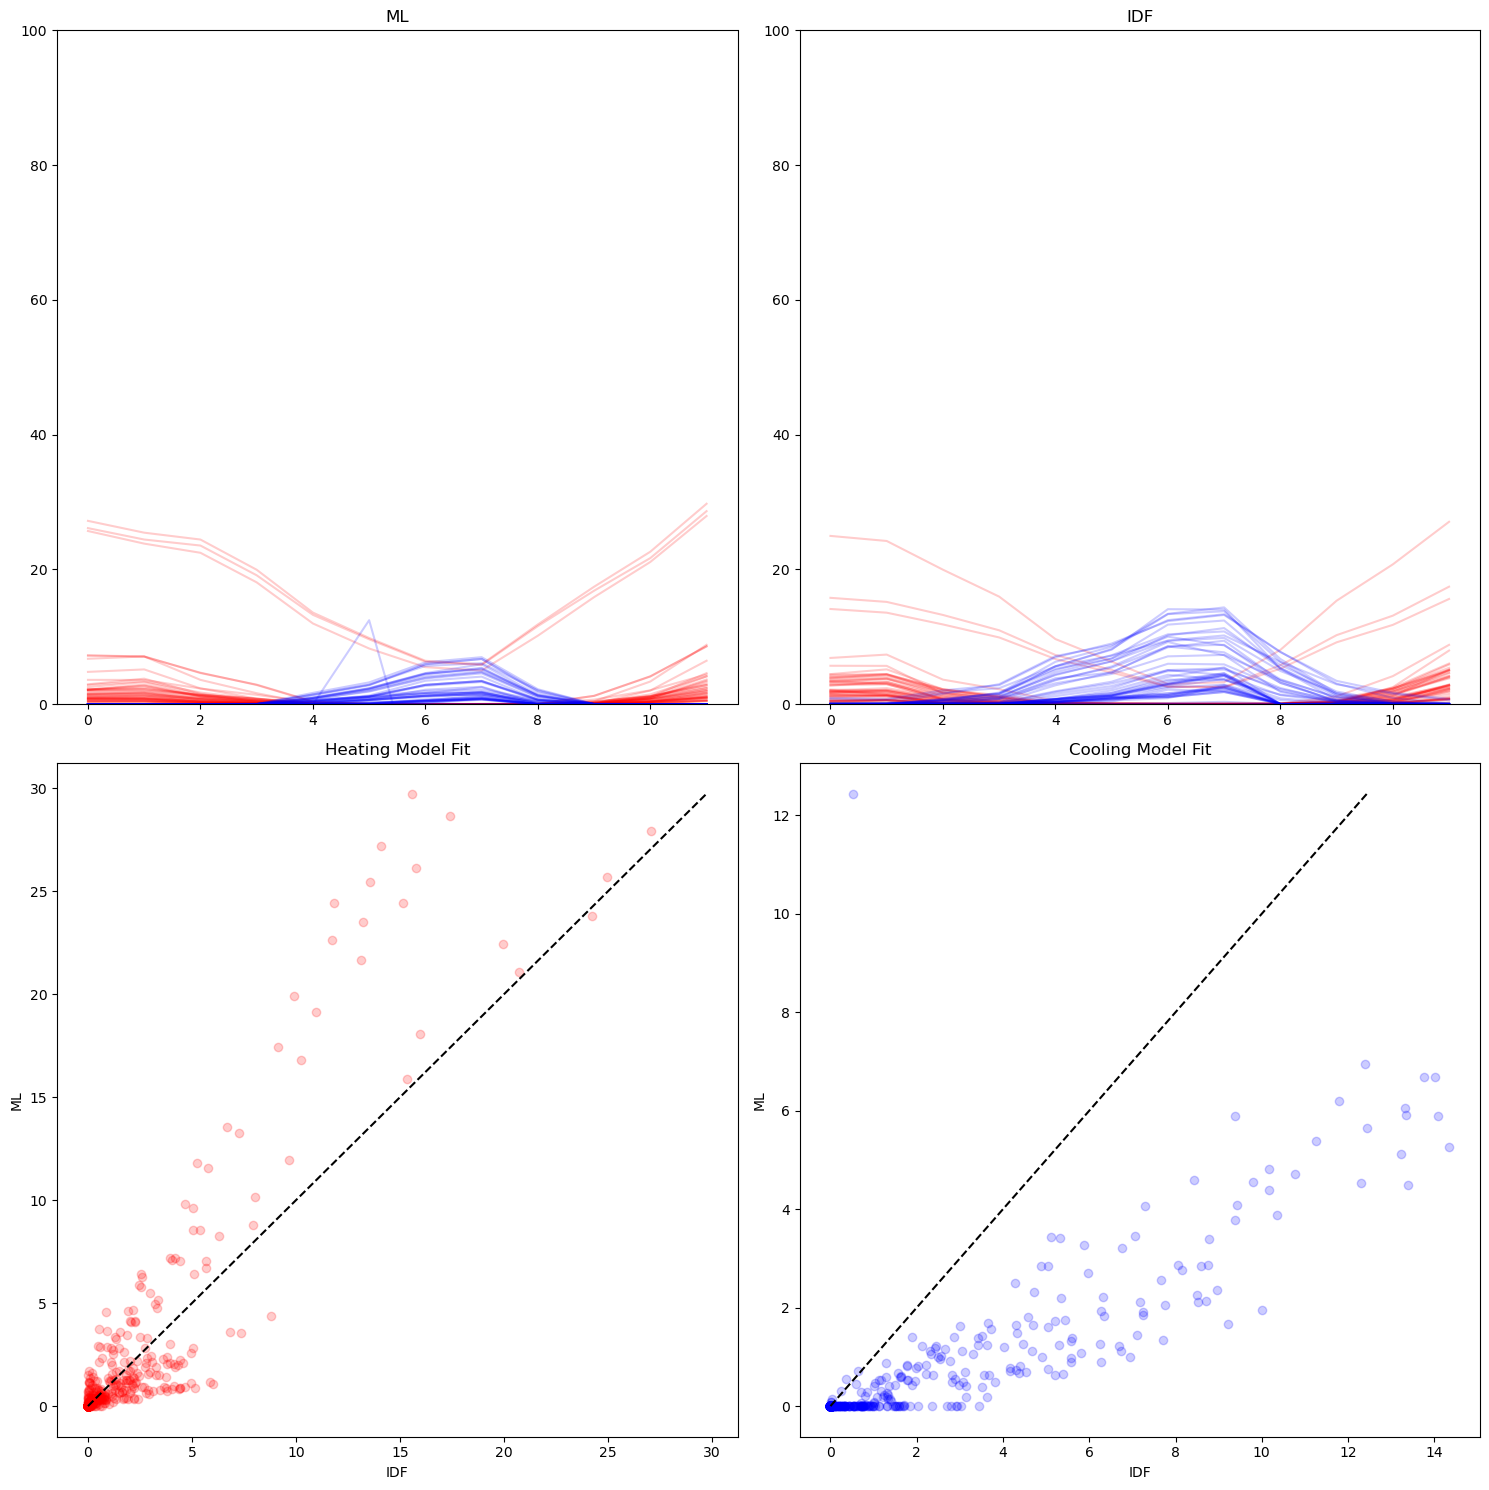

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ml_ax = ax[0, 0]
idf_ax = ax[0, 1]
scatter_h_ax = ax[1, 0]
scatter_c_ax = ax[1, 1]


ml_ax.plot(ml_monthly.Heating.values.T, color="red", alpha=0.2)



ml_ax.plot(ml_monthly.Cooling.values.T, color="blue", alpha=0.2)
idf_ax.plot(true_results["Heating:DistrictHeating"].values.T, color="red", alpha=0.2)
idf_ax.plot(true_results["Cooling:DistrictCooling"].values.T, color="blue", alpha=0.2)
ml_ax.set_ylim(0, 100)
idf_ax.set_ylim(0, 100)
ml_ax.set_title("ML")
idf_ax.set_title("IDF")
scatter_h_ax.set_title("Heating Model Fit")
scatter_h_ax.set_xlabel("IDF")
scatter_h_ax.set_ylabel("ML")
scatter_c_ax.set_title("Cooling Model Fit")
scatter_c_ax.set_xlabel("IDF")
scatter_c_ax.set_ylabel("ML")
scatter_h_ax.scatter(
    true_results["Heating:DistrictHeating"].values.flatten(),
    ml_monthly.Heating.values.flatten().clip(0, 1000),
    color="red",
    alpha=0.2,
)
scatter_c_ax.scatter(
    true_results["Cooling:DistrictCooling"].values.flatten(),
    ml_monthly.Cooling.values.flatten().clip(0, 1000),
    color="blue",
    alpha=0.2,
)
# plot identity line on top of scatter
x = np.linspace(0, np.max(ml_monthly.Cooling.values.flatten()), 100)
scatter_c_ax.plot(x, x, color="black", linestyle="--")
x = np.linspace(0, np.max(ml_monthly.Heating.values.flatten()), 100)
scatter_h_ax.plot(x, x, color="black", linestyle="--")
fig.tight_layout()

(0.0, 50.0)

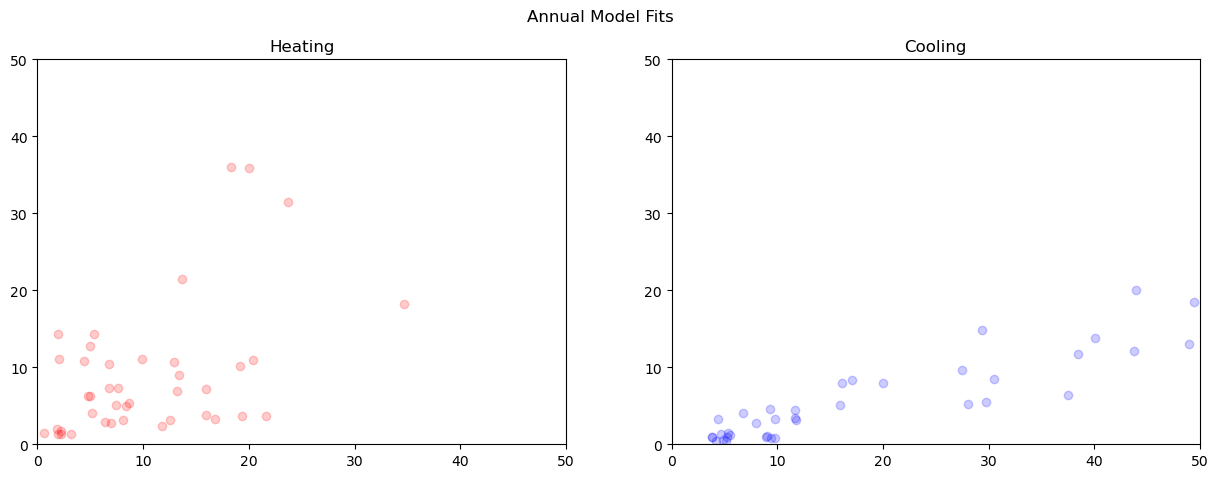

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Annual Model Fits")
h_ax = ax[0]
c_ax = ax[1]
h_ax.set_title("Heating")
c_ax.set_title("Cooling")

h_ax.scatter(
    true_results["Heating:DistrictHeating"].sum(axis=1),
    ml_annual.Heating,
    color="red",
    alpha=0.2,
)
h_ax.set_ylim(0, 50)
h_ax.set_xlim(0, 50)

c_ax.scatter(
    true_results["Cooling:DistrictCooling"].sum(axis=1),
    ml_annual.Cooling,
    color="blue",
    alpha=0.2,
)
c_ax.set_ylim(0, 50)
c_ax.set_xlim(0, 50)

In [31]:
len(parameters)

1112

<Axes: >

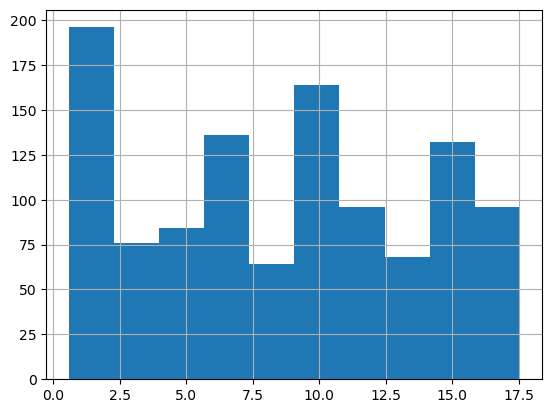

In [32]:
parameters.RoofRValue.hist()

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

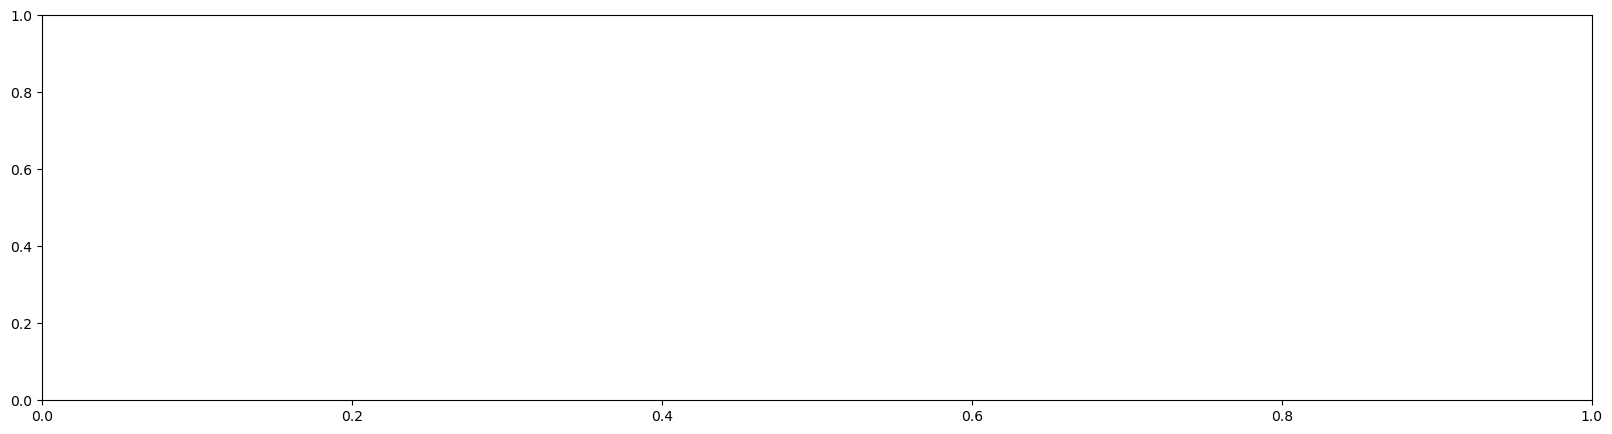

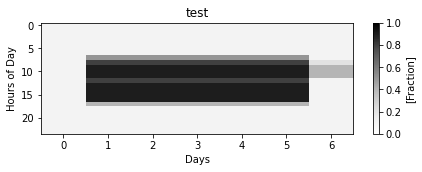

In [20]:
from archetypal.schedule import Schedule


fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sch = Schedule.from_values(Name="test", Values=scheds[0, 0, : 7 * 24])

sch